In [2]:
#%pip install timm

In [3]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x26d8860c9e0>)

In [4]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

a:\Python\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to C:\Users\Артём/.cache\torch\hub\master.zip
a:\Python\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureW

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
    

In [6]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\Артём/.cache\torch\hub\intel-isl_MiDaS_master


In [10]:
filename = (r"A:\zavod\123.jpg")

In [11]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [12]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

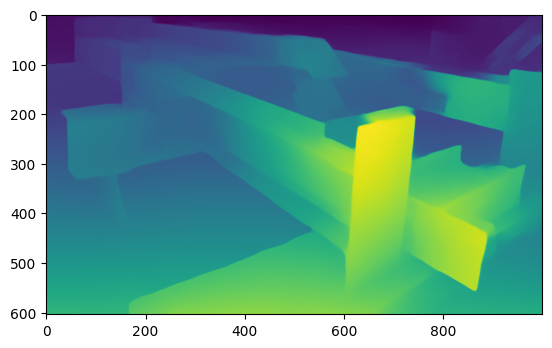

In [13]:
plt.imshow(output)
# plt.show()

In [18]:
#1 вариант

import cv2
import numpy as np
import open3d as o3d

# Загрузка изображения
img = cv2.imread(r'A:\zavod\glubina.jpg')  # Замените на путь к вашему файлу
height, width = img.shape[:2]

# Создание точек: каждая пиксель — точка (x, y, 0) с цветом (BGR -> RGB)
points = []
colors = []
for y in range(height):
    for x in range(width):
        if np.sum(img[y, x]) > 50:  # Фильтр: игнорируем чёрные пиксели (опционально)
            points.append([x, y, 0])  # Z=0 для 2D
            colors.append(img[y, x] / 255.0)  # Нормализованный цвет

# Конвертация в Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(points))
pcd.colors = o3d.utility.Vector3dVector(np.array(colors))

# Визуализация
o3d.visualization.draw_geometries([pcd])

In [20]:
#2 вариант 

import cv2
import torch
import numpy as np
import open3d as o3d
from torchvision.transforms import Compose
import urllib.request
import matplotlib.pyplot as plt  # Для отладки

# Загрузка модели MiDaS (один раз)
model_type = "DPT_Large"  # Или "MiDaS_small" для скорости
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to("cuda" if torch.cuda.is_available() else "cpu")  # GPU для ускорения
midas.eval()

# Трансформации для модели
transform = Compose([
    lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    lambda img: cv2.resize(img, (384, 384)),  # Минимальный размер для модели
])

# Загрузка и предобработка изображения
img = cv2.imread(r"A:\zavod\123.jpg")
input_img = transform(img)
input_tensor = torch.from_numpy(input_img).float().permute(2, 0, 1).unsqueeze(0) / 255.0
if torch.cuda.is_available():
    input_tensor = input_tensor.to("cuda")

# Предсказание глубины
with torch.no_grad():
    depth = midas(input_tensor)
    depth = torch.nn.functional.interpolate(
        depth.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# Нормализация глубины (0-1)
depth_min = depth.min()
depth_max = depth.max()
depth = (depth - depth_min) / (depth_max - depth_min)

# Создание 3D-точек: (x, y, depth) с цветом из оригинала
height, width = img.shape[:2]
points = []
colors = []
fx = fy = 500  # Фокусное расстояние (пример; подберите под камеру)
cx, cy = width / 2, height / 2  # Центр изображения

for v in range(height):
    for u in range(width):
        z = depth[v, u].item() * 10  # Масштабируем глубину (экспериментируйте)
        if z > 0:  # Игнорируем нулевую глубину
            x = (u - cx) * z / fx
            y = (v - cy) * z / fy
            points.append([x, y, z])
            colors.append(img[v, u] / 255.0)  # BGR -> RGB

# Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(points))
pcd.colors = o3d.utility.Vector3dVector(np.array(colors))

# Визуализация
o3d.visualization.draw_geometries([pcd])

# Сохранение (опционально)
o3d.io.write_point_cloud("point_cloud.ply", pcd)

Using cache found in C:\Users\Артём/.cache\torch\hub\intel-isl_MiDaS_master


True

In [21]:
# 3 вариант

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Пример данных (адаптируйте под ваши)
x = np.linspace(200, 800, 100)
y = np.linspace(0, 600, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X/100) * np.cos(Y/100) * 100  # Ваша поверхность

# Точки из сетки
points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
colors = plt.cm.viridis(Z / Z.max())  # Цвета

# Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

RuntimeError: Unable to cast Python instance of type <class 'numpy.ndarray'> to C++ type '?' (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)